# **Libraries**

In [1]:
# PyTorch
import torch
from torchvision import transforms, datasets, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch import optim, cuda
import pandas as pd
import os
# Visualizations
import matplotlib.pyplot as plt
from skimage import io, transform

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Timing utility
from timeit import default_timer as timer


# **Variables**

In [2]:
save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'
earlyStop= 5
epochsNo= 20

root_dir='/kaggle/input/fetal-head-thesis/training_set/training_set/'
csv_file='/kaggle/input/fetal-head-thesis/training_set_pixel_size_and_HC.csv'
img_size = 224
cropped_img = 224
batch_size = 100

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')

Train on gpu: True
2 gpus detected.


# **Data Analysis & Manipulation**

In [3]:
HC_df=pd.read_csv(os.path.join(csv_file))

from sklearn.model_selection import train_test_split
HC_df = HC_df[['filename','pixel size(mm)','head circumference (mm)']].drop_duplicates()
HC_df=HC_df[['filename','pixel size(mm)','head circumference (mm)']].copy().rename(columns={'pixel size(mm)':'pixel_size','head circumference (mm)':'HC'})

HC_df = HC_df[HC_df.filename.str.contains("_HC")]

train_df, test_val = train_test_split(HC_df, test_size = 0.3,random_state = 2020)
valid_df, test_df = train_test_split(test_val, test_size = 0.5,random_state = 2020)

# print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])
# train_df = train_df.groupby(['pixel_size', 'normalized_HC_pixels']).apply(lambda x: x.sample(2, replace = True)).reset_index(drop = True)
print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])

HC_df.describe()

train 564 validation 121 Test 121


,pixel_size,HC
count,806.000000,806.000000
mean,0.138848,173.971600
std,0.051949,64.761672
min,0.049415,44.300000
25%,0.108393,153.925000
50%,0.128191,174.225000
75%,0.157101,188.797500
max,0.393280,346.400000


In [4]:
HC_df.head()

,filename,pixel_size,HC
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


Text(0.5, 1.0, 'HC')

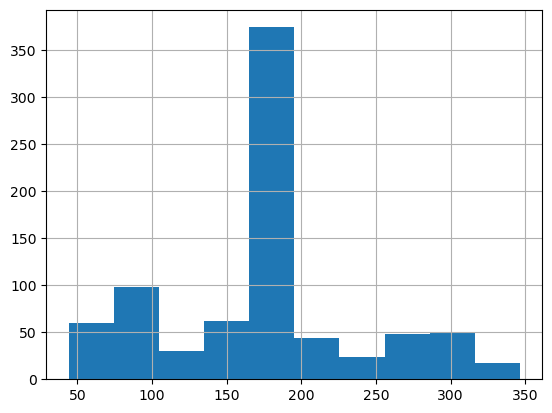

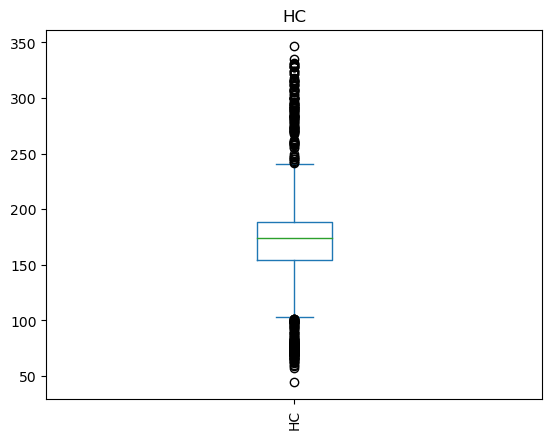

In [5]:
 # plot a histogram  
HC_df['HC'].hist(bins=10)
columns = ['HC']
HC_df[columns].plot.box()
plt.xticks(rotation='vertical')
plt.title('HC')

In [6]:
max_hc = HC_df['HC'].max()
print('max hc',max_hc)

max hc 346.4


In [7]:
train_df.to_csv("/kaggle/working/train_file.csv", index=False, encoding='utf8')

valid_df.to_csv("/kaggle/working/val_file.csv", index=False, encoding='utf8')

test_df.to_csv("/kaggle/working/test_file.csv", index=False, encoding='utf8')

# **Custom Dataset Class**

In [8]:
# Image manipulations
from PIL import Image

class HC_18(Dataset):
    """Head circumference estimation dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.HC_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.HC_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.HC_df.iloc[idx, 0])
        image = Image.open(img_name)
        features = self.HC_df.loc[idx,'HC']
        
        if self.transform:
            image = self.transform(image)
        return image , torch.tensor(features / 346.4)


# **Images Transformations**

In [9]:
image_transforms = {
    # Train uses data augmentation
    'train':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.RandomRotation(degrees=10),
#             transforms.GaussianBlur(5),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=cropped_img),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    # Validation does not use augmentation
    'val':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    # Test does not use augmentation
    'test':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

# **Dataloader**

In [10]:
train_filename='train_file.csv'
val_filename='val_file.csv'
test_filename='test_file.csv'

data = {'train': HC_18(train_filename ,root_dir = root_dir,transform = image_transforms['train']),
        'val': HC_18(val_filename ,root_dir = root_dir,transform = image_transforms['val']),
        'test': HC_18(test_filename ,root_dir = root_dir,transform = image_transforms['test'])
       }

# Dataloader iterators
dataloaders ={
    'train': DataLoader(data['train'], batch_size=batch_size,shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size,shuffle=False),
    'test': DataLoader(data['test'], batch_size=len(test_df),shuffle=False)
}

# **Model**

In [11]:
model = models.vgg16(pretrained=True)
n_inputs = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(n_inputs, 1 , bias = True)) 

print(model)

if train_on_gpu:
    model = model.to('cuda')


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Training Function**

In [12]:
# --------------------------------------Training
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=1):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch...\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0
        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target.float())
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Track training progress
            print( f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.float())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])
                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \t\tValidation Loss: {valid_loss:.4f}')

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch+1}. Best epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.')
    # Format history
    history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
    return model, history

# **Loss Function & Optimizer**

In [13]:
# --------------------------------------Optimizer
# criterion=nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.SmoothL1Loss(beta = 0.5)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

# **Training..**

In [14]:
# --------------------------------------Training
import numpy as np
model, history = train(model,criterion,optimizer,dataloaders['train'],dataloaders['val'],save_file_name=save_file_name,max_epochs_stop=earlyStop,n_epochs=epochsNo,print_every=1)
history.to_csv("/kaggle/working/history.csv", index=False, encoding='utf8')

Starting Training from Scratch...

Epoch: 1	100.00% complete. 29.40 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2530 		Validation Loss: 0.0404
Epoch: 2	100.00% complete. 14.52 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.0652 		Validation Loss: 0.0363
Epoch: 3	100.00% complete. 15.21 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0534 		Validation Loss: 0.0295
Epoch: 4	100.00% complete. 14.64 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.0489 		Validation Loss: 0.0288
Epoch: 5	100.00% complete. 14.62 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0451 		Validation Loss: 0.0288
Epoch: 6	100.00% complete. 14.74 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.0439 		Validation Loss: 0.0290
Epoch: 7	100.00% complete. 14.72 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0417 		Validation Loss: 0.0293
Epoch: 8	100.00% complete. 14.97 seconds elapsed in epoch.
Epoch: 8 	Training Loss: 0.0419 		Validation Loss: 0.0289
Epoch: 9	100.00% complete. 14

# **Results Graph**

Text(0.5, 1.0, 'Training and Validation Losses')

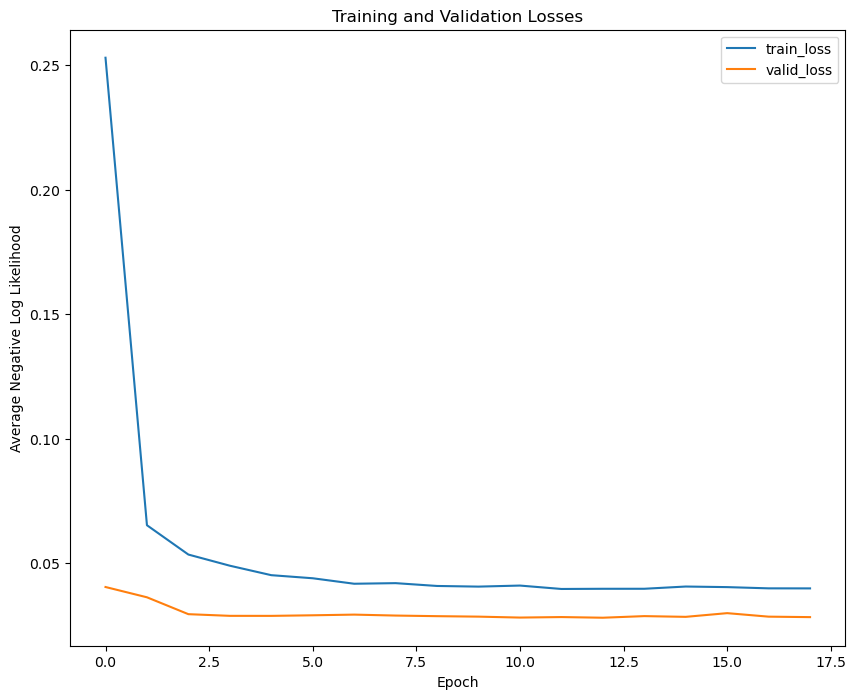

In [15]:
plt.figure(figsize=(10, 8))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch',color='k')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

# **Save Model**

In [16]:
def save_checkpoint(model, path):

    # Basic details
    checkpoint = {
                'epochs': model.epochs
                 }

    # Extract the final classifier and the state dictionary
    checkpoint['classifier'] = model.classifier
    checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    # Save the data to the path
    torch.save(checkpoint, path)
    

In [17]:
save_checkpoint(model, path=checkpoint_path)

# **Test the Model**

In [18]:

def check_mse_on_test(model, testloader, criterion=None, device='cpu'):  
    """
    Compute the Mean Square Error on the test dataset
    :param model - a pretrained model object
    :param testloader - a generator object representing the test dataset
    :param criterion - loss object
    :param device - a string specifying whether to use cuda or cpu
    return - MSE of predicted head circumference
    """
    loss = 0
    test_loss = 0
    std_mean = 0
    model.eval()
    test_dataframe = pd.read_csv(test_filename)
    with torch.no_grad():
        for data,target in testloader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)

            test_dataframe ['predicted output'] = np.squeeze(output.cpu().numpy())
            test_dataframe.to_csv("/kaggle/working/pred_test_file.csv", index=False, encoding='utf8')

            std_mean = torch.std_mean(output)
            loss = criterion(output, target.float())
            # Multiply average loss times the number of examples in batch
            test_loss += loss.item() * data.size(0)
            
    return std_mean , test_loss / len(testloader.dataset)

In [19]:
criterion = nn.L1Loss()

In [20]:
std_mean , test_loss = check_mse_on_test(model, dataloaders['test'], criterion, device='cuda')
print('Test set MAE loss = {:.4f} '.format(test_loss))
print('Test set standard deviation of Hc =  {:.4f} mm'.format(std_mean[0] * 346.4))
print('Test set MAE loss of HC = {:.4f} mm'.format(test_loss * 346.4))

Test set MAE loss = 0.1318 
Test set standard deviation of Hc =  9.2638 mm
Test set MAE loss of HC = 45.6634 mm
